In [1]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import time
%pylab inline

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(15,6)
# Functions used in generating synthetic data

#designate randomly selected points of time that have a phase slip 
def slipper(t_array,num, debug = False):
    #num: how many phase slips should be incorporated into the frequency
    #indexInt = random.randint(0,int(len(sz)/rate))
    ti = random.choice(arange(len(t_array)),num)
    return ti

#create Phase Map
def phase_map(t_array, loc,debug = False):
    slipSz = t_array.shape
    loc = np.sort(loc)
    PhaseMap = np.ones(slipSz)*(2*np.pi*random.rand(1)-np.pi)
    for point in loc:
        PhaseMap[point:] = 2*np.pi*random.rand(1)-np.pi
    return PhaseMap

#create Amplitude Map
def amp_map(t_array, slip_loc, freq, amp_i=1, mod=0.1, mod_amp=0.05,debug = False):
    #t_array: the time series values
    #          t_array[1] is used to find the sample rate that was used
    #loc: the index of random time points that a phase shift occurrs
    #freq: frequency that is being modeled. Gaussian width is dependant on freq
    #res_width: resonance width, the bandwidth over which the power of vibration is greater than 
    #               half the power at the resonant frequency
    #gauss_width: width of gaussian curve such that frequency decays to zero at 2 periods
    #amp_i: initial amplitude of function
    #mod: frequency of amplitude madulation
    #mod_amp: amplitude of amplitude modulation
    #debug: for debugging purposes
    
    period = 1/(freq)
    gauss_width = int(2*period*(1/t_array[1]))
    
    res_width = 0.0001
    res_freq = 1
    Q_factor = res_freq/res_width
    
    dropSz = t_array.shape
    slip_loc = np.sort(slip_loc)
    
    variance = 0.2*amp_i
    t1 =time.time()
    AmpMap = np.ones(dropSz)*amp_i + random.normal(0,variance,1)
    t2 = time.time()
    if debug:
        AmpMap2 = np.copy(AmpMap)
    for point in slip_loc:
        change_up = random.normal(0,variance,1)
        if debug:
            AmpMap2[point:] = 1*amp_i + change_up
        AmpMap[point:] = (1*amp_i + change_up)*exp(-(1/Q_factor)*(t_array[point:]-t_array[point]))
        AmpMap[int(point-gauss_width/2):int(point+gauss_width/2)] = 0
    t3 = time.time()
    
    window = signal.hamming(int(gauss_width))
#     method = signal.choose_conv_method(AmpMap, window, mode='same')
    AmpMap = signal.convolve(AmpMap,window, mode='same')/sum(window)
    AmpMap  = AmpMap #+ mod_amp*sin(2*pi*mod*t_array)
    t4 = time.time()
#     print(t2-t1,t3-t2,t4-t3,t4-t1, end='\r')
    if debug:
        return AmpMap,AmpMap2
    return AmpMap

def create_drive(zdata, dt2, tf, freqs):
    fbottom2 = np.fft.fft(zdata)
    freq2 = np.fft.fftfreq(len(zdata),dt2)
    freq2[freq2 > freqs[np.argmax(freqs)]] = freqs[np.argmax(freqs)]
    freq2[freq2 < freqs[np.argmin(freqs)]] = freqs[np.argmin(freqs)]
    
    driver = np.fft.ifft(tf(freq2)*fbottom2)
    return driver

def butterworth_lowpass(sig, cutoff, fs = 10000):
    sos = signal.butter(8, cutoff, 'lowpass', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, sig)
    return filtered

def geophone_response(sig, cutoff, fs = 10000, lor_width = 20):
    b,a = signal.butter(sig,cutoff, 'hp', fs = fs)
    w,h = signal.freqz(b,a)
    plt.semilogx(w, 1000*lorentzian(w,cutoff,lor_width)+ 20 * np.log10(abs(h)))
    filtered = 1000*lorentzian(w,cutoff,lor_width)+ 20 * np.log10(abs(h))

def resonant_filter(sig, w_res, res_width, fs = 10000):
    fft_sig = fft.fft(sig)
    fft_freq = fft.fftfreq(len(sig),1/fs)
    sos = signal.butter(8, 12, 'highpass', fs=fs, output='sos')
    filt_freq, filt_response = signal.sosfreqz(sos,worN=len(fft_sig),fs=fs)
    lor_response = lorentzian(fft_freq,w_res,res_width)
    res_response = 1*lor_response+(20*np.log10(absolute(filt_response)))
    res_response[int(len(res_response)/2)+1:] = np.flip(res_response[1:int(len(res_response)/2)])
    fft_filt = fft_sig*exp(res_response)
    fft_filt[0] = 0+0j
    return fft.ifft(fft_filt)

def butterworth_highpass(sig, cutoff, fs = 10000):
    sos = signal.butter(10, cutoff, 'hp', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, sig)
    return filtered

def view_debug(arg, amp = 1,slips = 2, freq = 10, secs = 10, fs=10000):
    
    t = linspace(0,secs,secs*fs)
    ti = slipper(t,slips)
    phase = phase_map(t, ti)
    amp,amp2 = amp_map(t, ti, freq,amp_i = amp,debug=True)

    freq1 = freq*2*np.pi
    wave = amp*sin(freq1*t + phase)
    fftData = fft.fft(wave)
    freqs = fft.fftfreq(len(fftData),1/fs)
    
    if arg == 'amp':
        plot(t,amp2)
        plot(t,amp)
        plot(t,wave)
        
    if arg == 'phase':
        plot(t,phase)
    
    if arg == 'wave':
        plot(t,wave)

    if arg == 'freq':
        freqs = freqs[:int(len(freqs)/2)]
        fftData = fftData[:int(len(fftData)/2)]
        plot(freqs,absolute(fftData))
        xlim(0,freq*2)
    
def noisy(t_array, amp, fs = 10000, cutoff = 300):
    noise = amp*randn(len(t_array))
#     sos = signal.butter(10, cutoff, 'low', fs = fs, output = "sos")
#     filtered = signal.sosfilt(sos, noise)
    return noise

def create_wave(freq_array, amp_array, secs = 10, fs = 10000, slips = 10,noise=True):

    t_array = linspace(0,secs,secs*fs)

    if noise:
        low_noise = noisy(t_array,0.0001)
    else:
        low_noise = 0
    #     Johnson = 0.005*randn(len(t))
    tempWave = np.zeros(len(t_array)) + low_noise
    for freq,ampi in zip(freq_array,amp_array):
        t2 = time.time()
        ampi = ampi/2000
        ti = slipper(t_array,slips)
        t3 = time.time()
        phase = phase_map(t_array,ti)
        t4 = time.time()
        amp = amp_map(t_array,ti,freq,amp_i = ampi)
        t5 = time.time()
        tempWave += amp*sin(2*np.pi*freq*t_array + phase)
        t6=time.time()
        print(t6-t2, end='\r')
    
    return tempWave, t_array

# Subtract mean and divide by range.
def normalize2(array):
    return (array-mean(array))/(max(array) - min(array))

def lorentzian(w, w0, g):
    return (1/pi) * (g/2) / ( (w-w0)**2 + (g/2)**2 )


# figsize(15,6)
# view_debug('amp',amp= 0.5,slips = 1,freq = 2,secs = 10)

## Environmental Vibrations

In [3]:
figsize(15,6)
#frequencies and magnitudes found upon inspection of data from 2019-02-25
freqs = [1.6, 2, 2.5, 30, 33, 34, 36, 50, 57, 59.5, 100, 101, 111,
         118, 125, 263, 264, 265, 266, 267, 270, 2000,2365,3955,3900,3950,3955,3951,3926,3989]
amps = [0.6, 0.3, 0.2, 0.25, 0.1, 0.12, 0.15, 0.01, 0.08, 0.04, 0.035, 0.08, 0.06,
        0.07, 0.05, 0.02, 0.015, 0.02, 0.01, 0.015, 0.01,0.03,0.019,0.001,0.014,0.023,0.016,0.015,0.012,0.01]
electric_freq = [60,120,180,240,300,360,420,480,540,600,660,720,780,840,900]
electric_amp =  [0.02,0.035,0.2,0.03,0.075,0.025,0.15,0.01,0.04,0.025,0.225,0.2,0.225,0.15,0.03]

start = time.time()
wave,t = create_wave(freqs, amps,secs = 1000,slips = 500)
elec_wave,t = create_wave(electric_freq,electric_amp,secs = 1000,slips=0,noise=False)
wave = wave + elec_wave
# for freq,amp in zip(electric_freq,electric_amp):
#     wave = wave + (amp/2000)*sin(freq*2*np.pi*t + (2*np.pi*random.rand(1)-np.pi))
print(time.time()-start,end= '\r')
# secs | slips | time per frequency | total time
# 100     1           0.1 s              4.1 s
# 100     10          0.2 s              6.1 s
# 100     100         0.9 s             32.07 s
# 1000    1           1.0 s             36.54 s
# 1000    10          2.0 s             61.61 s
# 1000    100         9.1 s            336.85 s
# 1200    100        11.5 s            390.46 s
# 1000    1000      116.5 s              ...

(10000000,) 0


Text(0.5, 1.0, 'Synthetic Geophone Frequency Response')

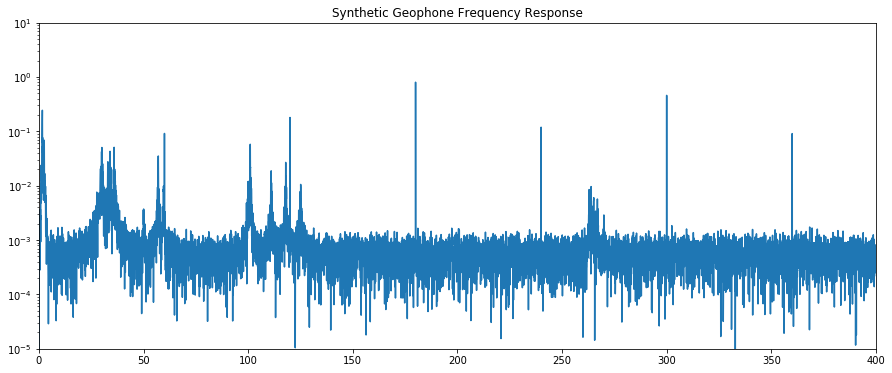

In [40]:
#Function finds the reshape value of the data to get closest to the desired frequency resolution
def res(freq_res, data_length, fs = 10000):
    # freq_res: desired frequency resolution
    # data_length: length of the data being transformed
    # fs: sampling rate that data was collected at (default=10000)
    #  Output:
    # Cuts: value that data can be reshaped as to reach desired resolution  
    cuts = int((data_length*freq_res)/fs)
    data_end = data_length%cuts
    return cuts,data_end

def array_avg(array):
    avg_vals = mean(array,axis=1)
    temp_array = np.zeros(shape(array))
    for i in arange(len(avg_vals)):
        temp_array[i,:] = array[i,:]-avg_vals[i]
    return(temp_array)

resolution = 0.05
len1 = len(wave)
cuts1,end1 = res(resolution,len1)
print(shape(wave),end1)
wave_avg = wave[:].reshape(cuts1,-1)
wave_fft = mean(fft.fft(array_avg(wave_avg)),axis=0)
freqs = np.fft.fftfreq(len(wave_fft),1/10000)
semilogy(freqs[:int(len(wave_fft)/2)],0.1*absolute(wave_fft[:int(len(wave_fft)/2)]))
xlim(0,400)
ylim(1e-5,1e1)
title('Synthetic Geophone Frequency Response')

1000000


Text(0.5, 1.0, 'Synthetic Geophone Data')

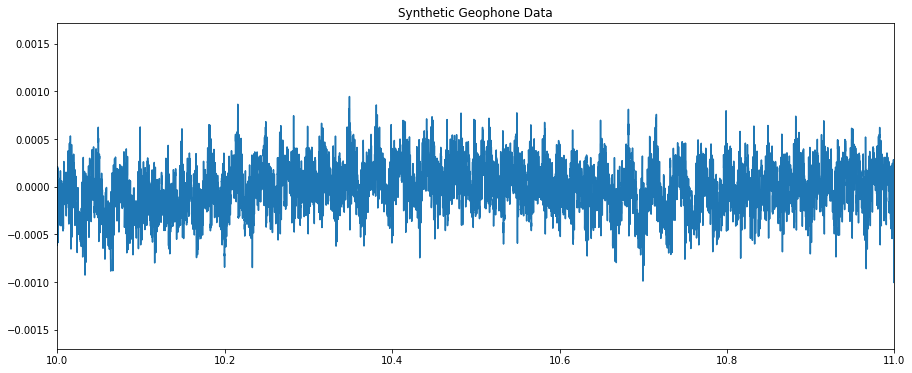

In [4]:
print(len(wave))
plot(t,wave)
xlim(10,11)
title('Synthetic Geophone Data')

## Geophone Data

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in log10


1.49664616584777832


Text(0.5, 1.0, 'Synthetic Geophone Frequency Response')

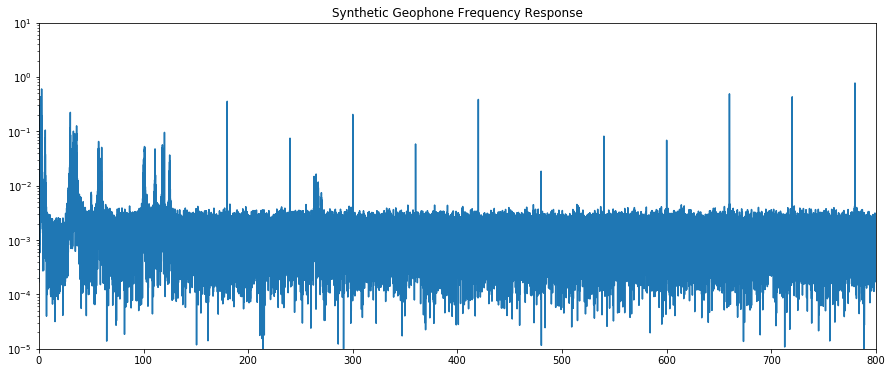

In [5]:
#put data through a high pass filter
# 
noise_freq = [0.1, 0.5, 1.8, 2.6, 3.1,5.7,6.1,16]
noise_amp = [0.25,0.2,0.5,0.425,0.15,0.05,0.1]
start = time.time()
geo = resonant_filter(wave,30,6)
geo1,t = create_wave(noise_freq, noise_amp,secs = 100,slips = 10) 
geo = geo+geo1
print(time.time()-start)
fft_geo = fft.fft(geo)
freq_geo = fft.fftfreq(len(geo),1/10000)
semilogy(freq_geo[:int(len(fft_geo)/2)],abs(fft_geo[:int(len(fft_geo)/2)]/100))
# plot(t,wave,label='Environmental Vibrations')
# plot(t,geo,label='Geophone Response')
xlim(0,800)
ylim(1e-5,10)
title('Synthetic Geophone Frequency Response')
# print(fft_geo[1],type(fft_geo[1]))
# legend()

In [6]:
# folder_loc = 'Albert_Data/2019-02-21/'
# file_loc = 'fast-transfer-function-'
# dat2 = np.loadtxt(folder_loc+file_loc+'001'+'.dat',skiprows=6)

# for j in arange(2,1000):
#     file = folder_loc+file_loc+str(j).zfill(3)+'.dat'
#     try:
#         temp_dat = np.loadtxt(file, skiprows=6)
#         dat2 = np.concatenate((dat2,temp_dat))
#         print(j,end='\r')
#     except:
#         pass

## Tip Data
### Idealized Transfer Function

0.05


(0, 200)

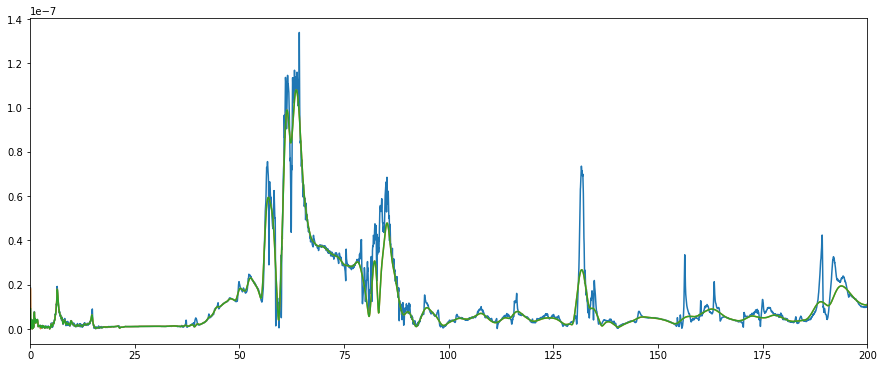

In [8]:
figsize(15,6)
#load real, calibrated transfer function
[transf_Alb, freqs_Alb] = joblib.load('Albert_Data/2019-02-26/trx2_v2')

transf = transf_Alb
freqs = freqs_Alb
lnfrq = int(len(freqs)/2)
print(freqs[1])
#create log spaced 
w_log = logspace(log10(freqs[1]),log10(freqs[-1+int(len(freqs)/2)]),100000)

T_log = transf(w_log) #transf is already an interpolation of frequencies

window = signal.hamming(int(300))
T_flt = signal.convolve(T_log,window, mode='same')/sum(window)

plot(w_log,absolute(T_log))
plot(w_log,absolute(T_flt))


f = scipy.interpolate.interp1d(w_log,T_flt, kind='linear')

w_lin = linspace(w_log[0],w_log[-1],lnfrq-1)
transf_flt = np.zeros(shape(freqs),dtype=np.complex64)

transf_flt[1:lnfrq] = f(w_lin)
transf_flt[lnfrq:] = np.flip(transf_flt[:lnfrq])

interp_transf = scipy.interpolate.interp1d(freqs,transf_flt, kind='linear')

plot(freqs[:lnfrq],absolute(transf_flt[:lnfrq]))
# plot(freqs,abs(transf_flt))
xlim(0,200)

(0, 200)

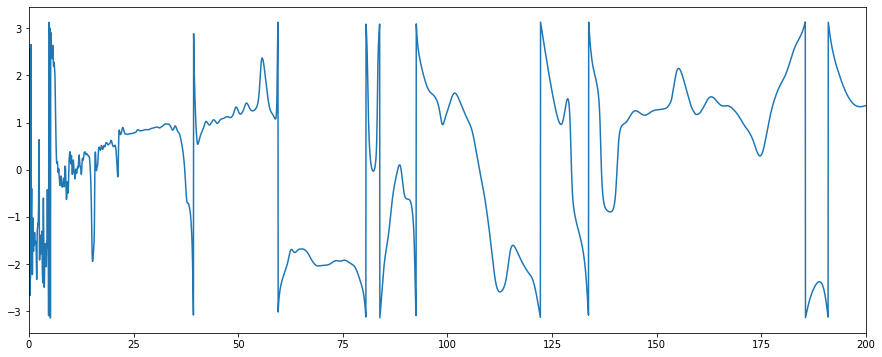

In [9]:
plot(freqs[:lnfrq],angle(transf_flt[:lnfrq]))
xlim(0,200)

### Tip Data created + harmonics 

In [8]:
# def create_tip_wave(g_dat, transfer_function, freqs, harmonic_freqs, harmonic = 6):
#     tf = transfer_function(freqs)
#     posfrq = int(len(tf)/2)
#     fft_g = fft.fft(g_dat)
#     tip_dat = np.zeros(shape(g_dat),dtype=type(g_dat[0]))
#     fft_harm = np.zeros((harmonic,len(tf)),dtype=type(fft_g[0]))
#     fft_mag = np.zeros((harmonic,len(tf)),dtype=type(fft_g[0]))
#     fft_index = np.zeros((harmonic,len(tf)),dtype=type(fft_g[0]))
#     for w in harmonic_freqs:
#         num = arange(harmonic)+2
#         harmonics = w*num
#         amps = 1/num
        
        
        
# arr = [1,2,3,4,5]
# harmonic = 3
# num = (arange(harmonic)+1)*2+1
# for w in arr:
    
#     harmonics = w*num
#     amps = 1/num
#     print(harmonics,amps)
        

def create_tip_data_3d(g_dat, transfer_function, freqs,harmonic_freqs, decay = 0.05, lockin = 1250):
    tf = transfer_function(freqs)
    fft_g = fft.fft(g_dat)
    lenfrq = int(len(fft_g)/2)
    lock_index = (np.abs(freqs - lockin)).argmin()
    tip_dat = np.zeros(shape(g_dat),dtype=complex128)
    fft_harm = np.zeros((20,len(fft_g)),dtype=complex128)
    transf_mag = np.zeros((20,len(fft_g)),dtype=complex128)
    transf_index = np.zeros((20,len(fft_g)))
    for w in harmonic_freqs:
        w = (np.abs(freqs - w)).argmin()
        harmonics = [int(w*3),int(w*5),int(w*7),int(w*9),int(w*11),int(w*13),int(w*15),int(w*17),int(w*19),int(w*21),
                    int(w*23),int(w*25),int(w*27),int(w*29),int(w*31),int(w*33),int(w*35),int(w*37),int(w*39),int(w*41)]
#         amps = [decay**1,decay**2,decay**3,decay**4,decay**5,decay**6,decay**7,decay**8,decay**9,decay**10,
#                decay**11,decay**12,decay**13,decay**14,decay**15,decay**16,decay**17,decay**18,decay**19,decay**20]
        amps = [1/3,1/5,1/7,1/9,1/11,1/13,1/15,1/17,1/19,1/21,1/23,1/25,1/27,1/29,1/31,1/33,1/35,1/37,1/39,1/41]
        transf_index[:,w]= np.asarray(harmonics)
        
        transf_mag[:,w] = np.asarray(amps)*fft_g[w]
        
    transf_index = transf_index.astype(int)
    count = 1
    for a in arange(len(transf_index[0,:])):
        neg = (1)**count
        for b in arange(len(transf_index[:,0])):
            index = transf_index[b,a]
            mag = transf_mag[b,a]
            if index > lenfrq:
                if index < len(tf):
                    index = len(tf) - index
                else:
                    index,mag = 0,0
            fft_harm[b,index] = complex(mag.real,neg*mag.imag)
#             print(mag)
#             fft_harm[b,index] = mag
        count = count+1
#     for index,mag in zip(transf_index.flatten(),transf_mag.flatten()):
#         if index > lenfrq:
#             if index < len(tf):
#                 transf_index[count] = len(tf) - index
#             else:
#                 transf_index[count],transf_mag[count] = 0,0
    fft_harm[:,lenfrq+1:] = np.flip(-fft_harm[:,1:lenfrq],axis=1)
    terp_tran_1 = scipy.interpolate.interp1d(freqs,tf, kind='linear')
    
    temp_tip = create_drive(g_dat,1/10000,terp_tran_1,freqs)
#     print(len(temp_tip),len(g_dat))
    for c in arange(20):
#         print(len(fft.ifft(fft_harm[c,:])))
        temp_tip = temp_tip + fft.ifft(fft_harm[c,:])
        
#     temp_fft = fft.fft(temp_tip)
#     temp_fft[lock_index:2*lock_index] = 1e-1*temp_fft[:lock_index]
#     temp_fft[:lock_index]
    
    tip_dat = temp_tip
    return tip_dat,terp_tran_1

In [9]:
# t= linspace(0,1,10000)
# wave = 1*sin(20*2*np.pi*t)
# harmonic = [20]
# tf = np.ones(len(fft.fft(wave)))
# freq = fft.fftfreq(len(tf),1/10000)
# tf = scipy.interpolate.interp1d(freq,tf, kind='linear')

# new_wave,transf = create_tip_data_3d(wave,tf,freq,harmonic,decay = 0.5)
# plot(t,wave)
# plot(t,new_wave)


In [10]:
# count = 0
# freq = 3
# t = linspace(0,1,10000)
# wav = np.zeros(len(t))
# for harm in arange(100):
#     freq_harm = freq*(harm*2+1)
#     neg = (1)**count
#     amp =(1/(harm*2+1))
#     wav = wav+amp*neg*sin(freq_harm*2*np.pi*t)
#     count += 1
    
#     fft_wav = fft.fft(wav)
#     fft_wav3 = fft_wav/3
#     wav3 = fft.ifft(fft_wav3)
    
#     mag = max(abs(fft_wav))
#     mag3 = max(abs(fft_wav3))
    
# #     print(mag,mag3)
# plot(t,wav)
# # plot(t,wav3)
# # xlim(0,0.1)

In [11]:
# freq = 5
# t = linspace(0,1,10000)
# # saw = signal.sawtooth(freq*2*np.pi*t)
# # plot(t,saw)

# wav = np.zeros(len(t))
# count = 1
# for harm in arange(5):
#     freq_harm = freq*(harm+1)
#     neg = (-1)**count
#     amp =-(1/(harm+1))
#     wav = wav+(2/np.pi)*amp*neg*sin(freq_harm*2*np.pi*t)
#     count += 1
    
#     fft_wav = fft.fft(wav)
#     fft_wav3 = fft_wav/3
#     wav3 = fft.ifft(fft_wav3)
    
#     mag = max(abs(fft_wav))
# plot(t,sin(freq*2*np.pi*t))
# plot(t,wav)
    
# # plot(fft.fftfreq(len(saw),1/10000),absolute(fft.fft(saw)))
# # xlim(0,20)

22.769062757492065


(0, 200)

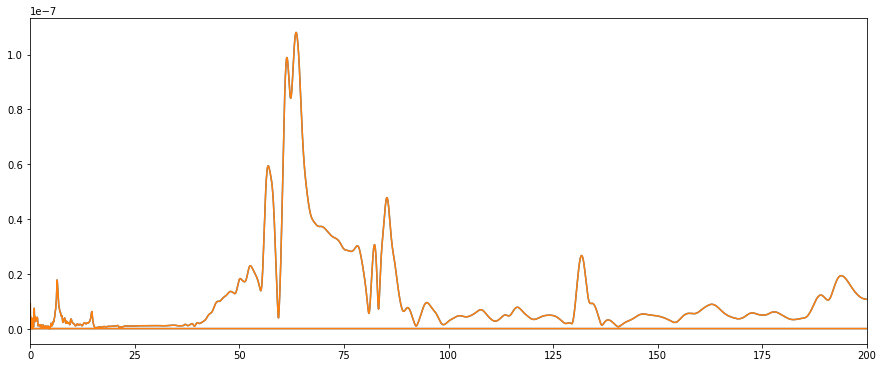

In [12]:
[transf, freqs] = joblib.load('Albert_Data/2019-02-26/trx2_v2')
start = time.time()
harm_freqs = [56.7,56.9,57,57.1,57.3,57.7,50,50.2]
# print(len(wave))
start = time.time()
tip_data, transf_harm = create_tip_data_3d(wave,interp_transf,freqs,harm_freqs,decay=0.5)
print(time.time()-start)
plot(freqs,absolute(transf_harm(freqs)))
plot(freqs,absolute(interp_transf(freqs)))

# print(time.time()-start)
xlim(0,200)
# # ~3 sec to iterate in entirety when all frequencies have harmonics 
# # ~1 sec to iterate only driven harmonics

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


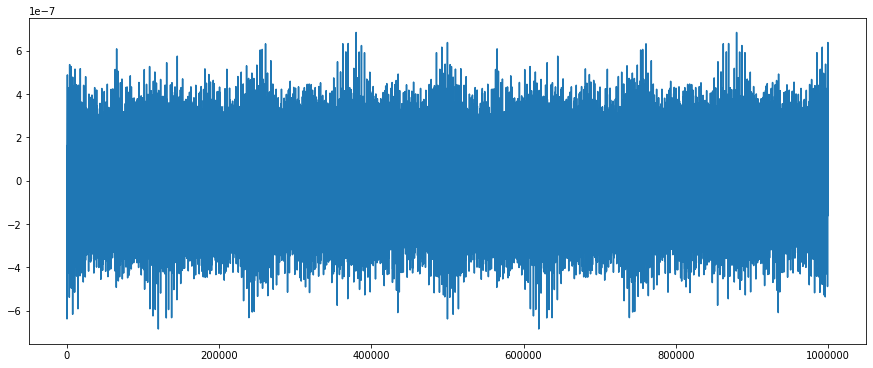

In [13]:
plot(tip_data)
# xlim(0,1)

(0, 400)

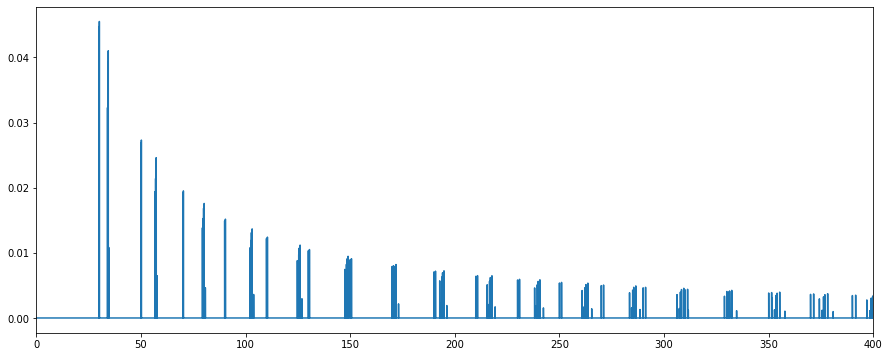

In [14]:
fft_tip = fft.fft(tip_data)
freqs_tip = fft.fftfreq(len(fft_tip),1/10000)
# fig,ax = subplots(2,1)
# ax[0].plot(freqs_tip[:int(len(freqs_tip)/2)],absolute(fft_geo[:int(len(freqs_tip)/2)]))
plot(freqs_tip[:int(len(freqs_tip)/2)],absolute(fft_tip[:int(len(freqs_tip)/2)]))
# ax[0].set_xlim(0,1000)
xlim(0,400)

### Transfer function creation

In [15]:
#Function finds the reshape value of the data to get closest to the desired frequency resolution
def res(freq_res, data_length, fs = 10000):
    # freq_res: desired frequency resolution
    # data_length: length of the data being transformed
    # fs: sampling rate that data was collected at (default=10000)
    #  Output:
    # Cuts: value that data can be reshaped as to reach desired resolution  
    cuts = int((data_length*freq_res)/fs)
    data_end = data_length%cuts
    return cuts,data_end

calibration_length = int(0.9*len(geo))
resolution = 0.1
cuts,end = res(resolution,calibration_length)

geo_cal, geo_test = geo[:calibration_length-end],geo[calibration_length:]
tip_cal, tip_test = tip_data[:calibration_length-end],tip_data[calibration_length:]

print(len(geo_cal))
nc = cancel.Cancel(geo_cal,tip_cal,1/10000,p=[350000,50000,5])
transf = nc.transf
freqs = nc.freqs

900000


(0, 200)

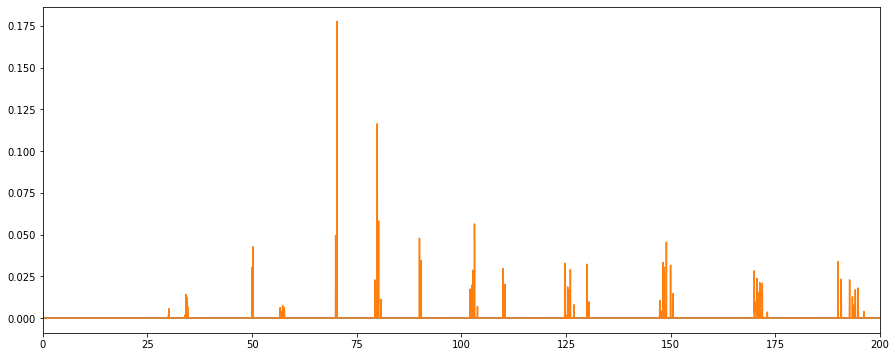

In [16]:
plot(freqs[:int(len(freqs_Alb)/2)],absolute(transf_harm(freqs[:int(len(freqs_Alb)/2)])))
plot(freqs[:int(len(freqs)/2)],absolute(transf(freqs[:int(len(freqs)/2)])))
xlim(0,200)

### Z Cancellation

(2, 2.5)

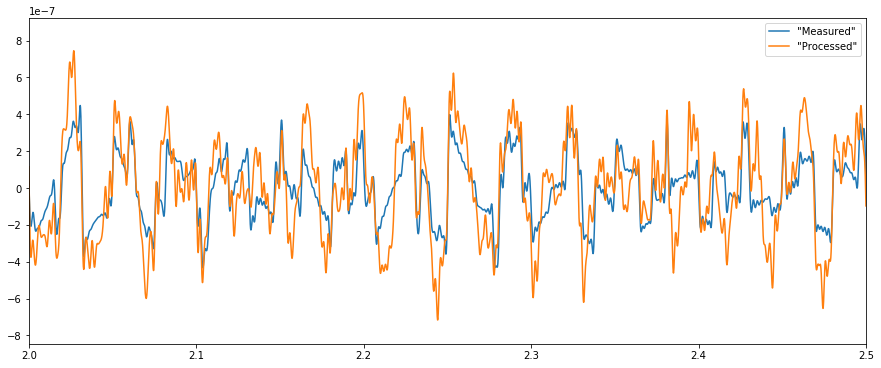

In [32]:
t= linspace(0,len(tip_data)/10000,len(tip_data))
z_noise = create_drive(geo_test,1/10000,transf,freqs)

plot(t[:len(tip_test)],tip_test,label='"Measured"')
plot(t[:len(tip_test)],tip_test-z_noise,label='"Processed"')
legend()
xlim(2,2.5)

In [29]:
rms_tip = (np.sqrt(np.mean(tip_test**2)))
rms_cancelled = (np.sqrt(np.mean((tip_test-z_noise)**2)))
#print(rms_cancelled,rms_tip)
print(str(round(100-100*abs(rms_cancelled/rms_tip),2))+'% RMS cancellation')

-190.84% RMS cancellation


### Current Data

-16313539785.538061


C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


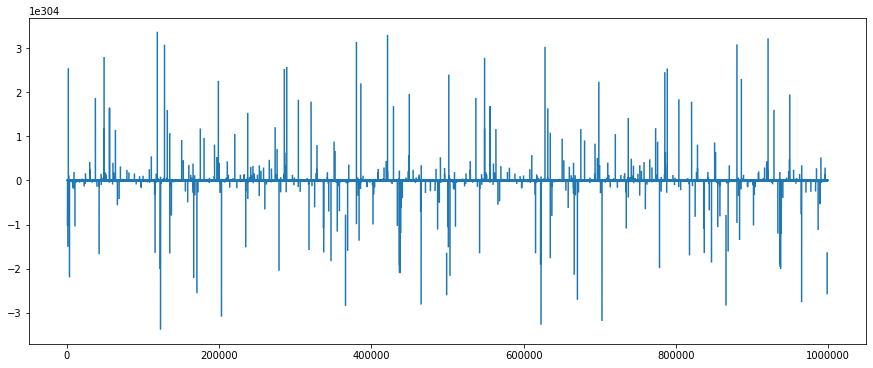

In [30]:
foldername='Albert_Data/2019-02-25/'
z_spec=loadtxt(foldername+'Z-Spectroscopy-noisy001.dat',skiprows=62)
fit = polyfit(z_spec[:,0],log(abs(z_spec[:,1])),1)
kappa = -2e10#fit[0]
print(fit[0])
I_0 = 200e-6
cur = I_0*exp(-kappa*tip_data)
plot(cur)
# xlim(0,0.1)

### Current with Modulation

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


(0, 0.1)

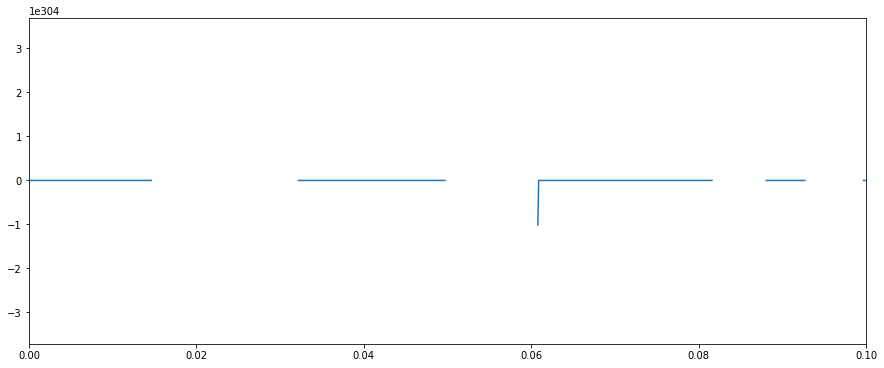

In [31]:
v_dc = np.zeros(len(cur))
v_mod = 1250
mod_amp = 1e-6

v_dc = v_dc + I_0

VMap = v_dc + mod_amp*sin(2*np.pi*v_mod*t)

cur_mod = VMap*exp(-kappa*tip_data)
# plot(t,cur_mod)
plot(t,cur_mod)
xlim(0,0.1)

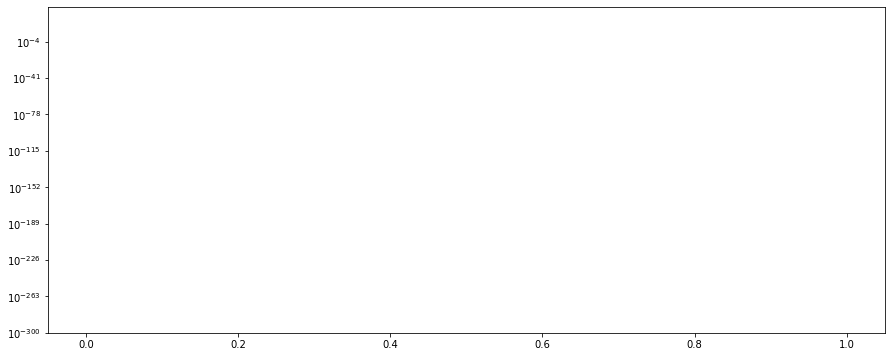

In [21]:
semilogy(fft.fftfreq(len(cur_mod),1/10000),abs(fft.fft(cur_mod-mean(cur_mod))))
# xlim(1050,1450)
# ylim(1e-7,0.8)

(1e-06, 2)

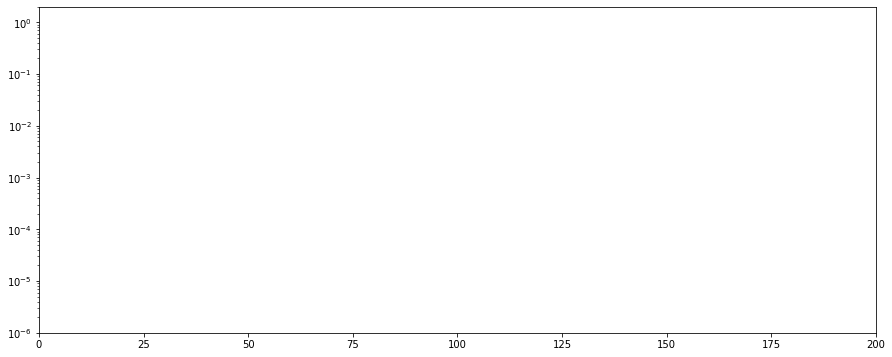

In [22]:
semilogy(fft.fftfreq(len(cur_mod),1/10000),abs(fft.fft(cur_mod-mean(cur_mod))))
xlim(0,200)
ylim(1e-6,2)

### LIX Data

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


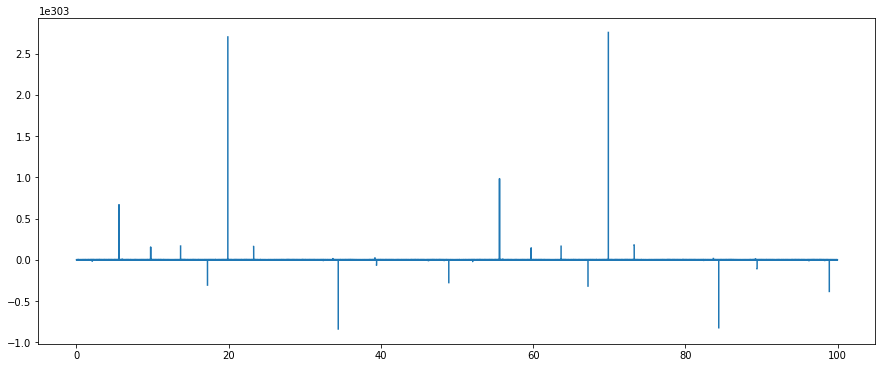

In [23]:
coefficient = v_mod/10000
v_ac = cos(500*2*pi*t)
a = 0
# print(coefficient,shape(cur_mod),shape(v_ac),shape((cur_mod*v_ac)))
lix_calc = repeat(coefficient*sum((cur_mod*v_ac).reshape(-1,20), axis=1),20)
# plot(v_ac[::40])
plot(t,lix_calc)
# xlim(0,0.2)
# print(len(lix_calc))

## Exact Propogation

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in true_divide
  
C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


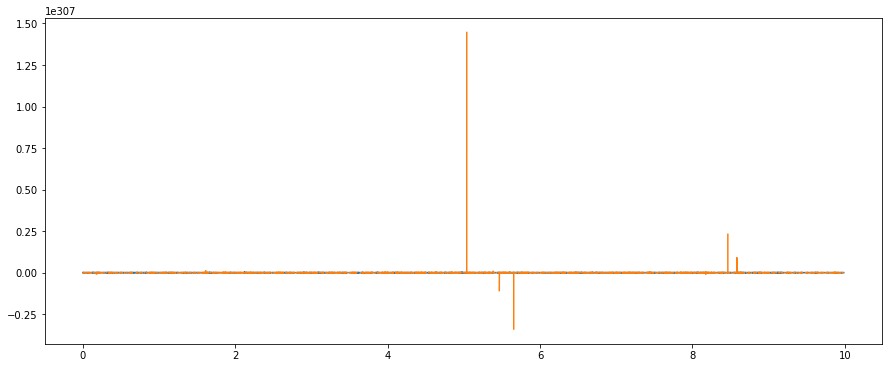

In [24]:
cur_noise = exp(-(z_noise-mean(z_noise))*kappa)
cur_cal, cur_test = cur[:calibration_length-end],cur[calibration_length:]

figsize(15,6)
t = linspace(0,len(cur_test)/10000,len(cur_test))
cur_correct = cur_test/(cur_noise)

plot(t,cur_test)
plot(t,cur_correct)
# xlim(0,40)